Can I automateish the line measurements?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
linelist = Table.read('/home/david/work/muscles/SEDs/lines/FUV_linelist.csv')

In [4]:
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')

In [5]:
w, f , e = np.array(t1data['WAVELENGTH']), np.array(t1data['FLUX']), np.array(t1data['ERROR'])

In [6]:
cos_cut = (w > 1100) & (w < 1210) | (w > 1220) & (w < 3100) 
w, f, e = w[cos_cut], f[cos_cut], e[cos_cut]

In [7]:
mw = np.arange(w[0], w[-1], 0.01)

In [8]:
high = linelist[linelist['Likelihood to measure'] =='High'] 

(1600.0, 1700.0)

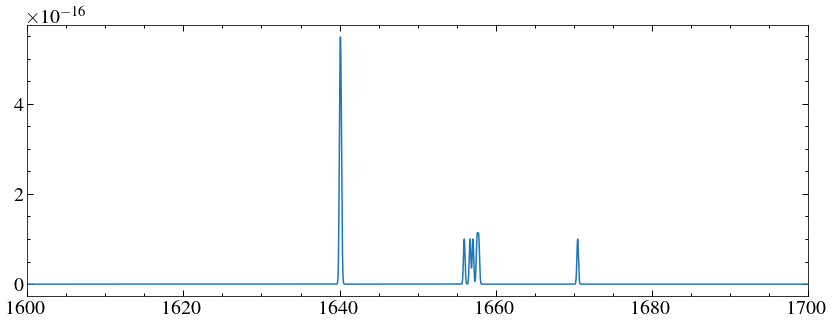

In [9]:
dv = -56.3*u.km/u.s

m_init = models.Const1D(0)
for line in high['Wavelength']:
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    m_init+= models.Gaussian1D(1e-16, li, 0.1, fixed=dict(mean=True, stddev=True))
    
plt.plot(mw, m_init(mw))
plt.xlim(1600, 1700)    

In [10]:
smooth = 5
f1 = convolve(f,Box1DKernel(smooth))
e1 = convolve(e,Box1DKernel(smooth))/smooth**0.5

In [11]:
fitter = fitting.LevMarLSQFitter()

In [12]:
m_fit = fitter(m_init, w, f1, weights = 1/e1, maxiter=10000)

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/modeling/fitting.py:831: RuntimeWarning: invalid value encountered in multiply
  return np.ravel(weights * (model(*args[2: -1]) - meas))


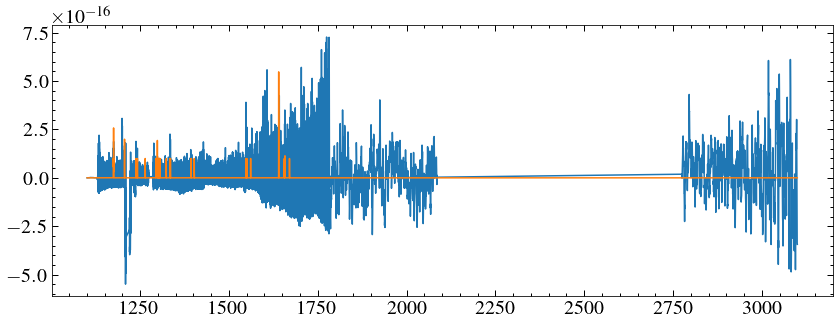

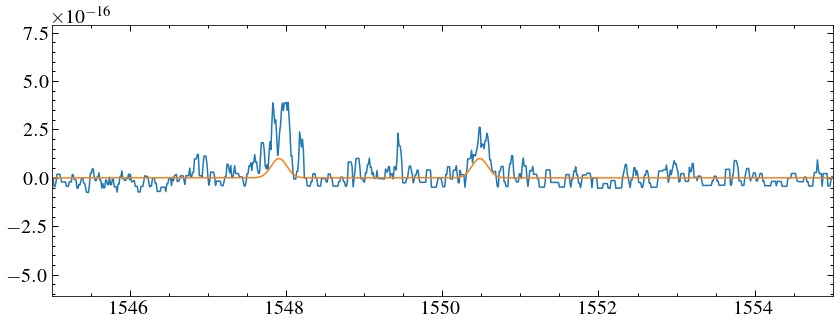

In [13]:
plt.plot(w, f1)
plt.plot(mw, m_fit(mw))
plt.show()

plt.plot(w, f1)
plt.plot(mw, m_fit(mw))
plt.xlim(1545, 1555)
plt.show()

Alternativly: Just integrate over range and model with fixed width.

In [46]:
lines = np.array(high['Wavelength'])
names = np.array(high['Ion'])
dv_lines =  dv.to(u.AA, equivalencies=u.doppler_optical(lines*u.AA)).value

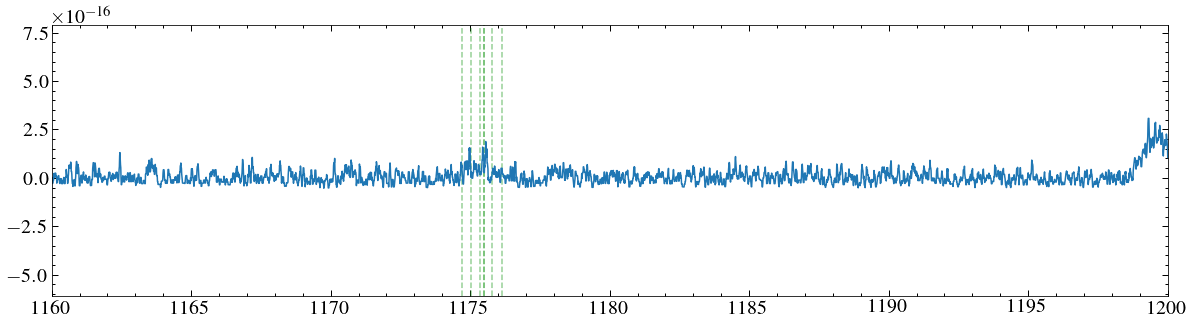

(1540.0, 1700.0)

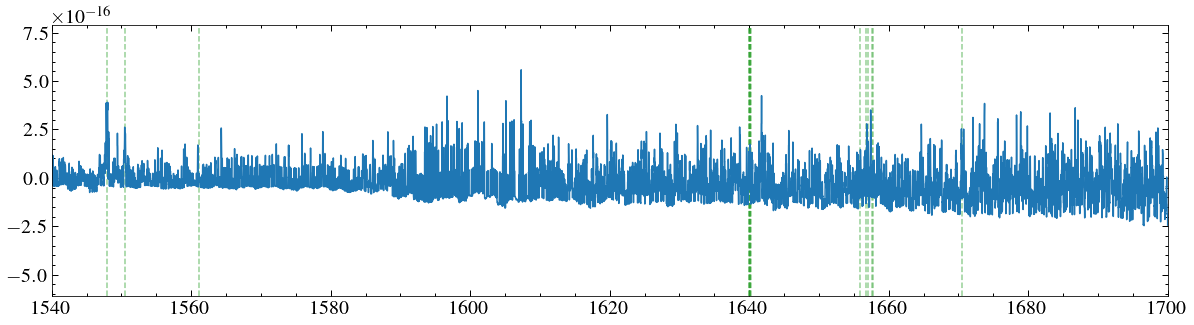

In [28]:

plt.figure(figsize=(20, 5))
[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in dv_lines]
plt.plot(w, f1)
plt.xlim(1160, 1200)
plt.show()
plt.figure(figsize=(20, 5))
[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in dv_lines]
plt.plot(w, f1)
plt.xlim(1540, 1700)

In [73]:
#combining close lines

grouped_lines = []
group = []
grouped_names = [] #double check two lines with the same name aren't being squished up
name_group = []
for i,line in enumerate(dv_lines):
    if line - lines[i-1] < 0.9:
        group.append(line)
        name_group.append(names[i])
        
    else:
        grouped_lines.append(group)
        grouped_names.append(name_group)
        group = [line]
        name_group = [names[i]]
print(grouped_lines)
print(grouped_names)
combined_lines = []
for group in grouped_lines:
    combined_lines.append(np.mean(group))
#print(combined_lines)

[[976.8385186043473], [1036.8252511848048], [1174.7143512187022, 1175.044289245829, 1175.3712278363455, 1175.4922051129586, 1175.4922051129586, 1175.768153281101, 1176.1510813550087], [1206.2724236072745, 1206.2724236072745], [1238.5883536460346], [1242.5706056522345], [1264.4994867097225], [1294.299889244692], [1298.6480725173415, 1298.700062751919], [1300.9026490360407, 1301.9244571079305], [1303.0782403906708, 1304.124043955442, 1304.6129521229116], [1305.78373221311], [1323.7033663349064], [1334.2733809494032], [1335.4581584104494], [1393.493257569842], [1402.5065645836228], [1547.9102531383828], [1550.4807703133613], [1561.1447672749794], [1640.0239512511553, 1640.0369488097997, 1640.066943175902, 1640.082940171157, 1640.16592458404, 1640.1819215792948, 1640.2249135040415], [1655.9559587125639, 1656.6968195552938, 1657.0677498827606, 1657.5956507261633, 1657.8106103498976]]
[['C III'], ['C II'], ['C III', 'C III', 'C III', 'C III', 'C III', 'C III', 'C III'], ['Si III', 'Si III'],

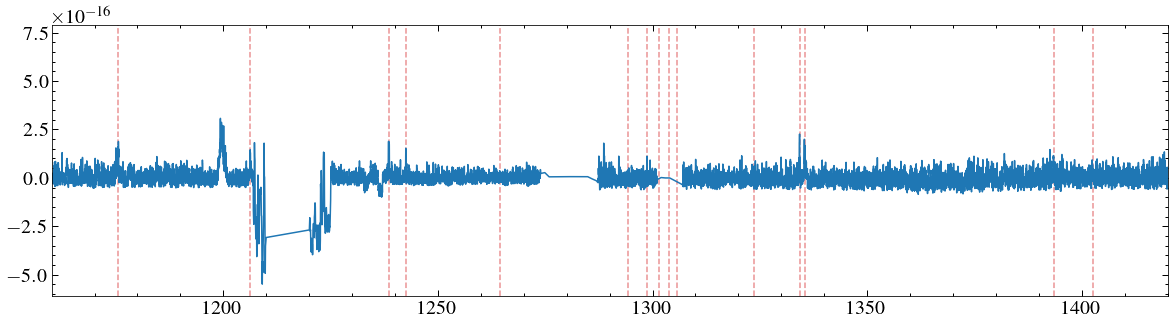

(1540.0, 1700.0)

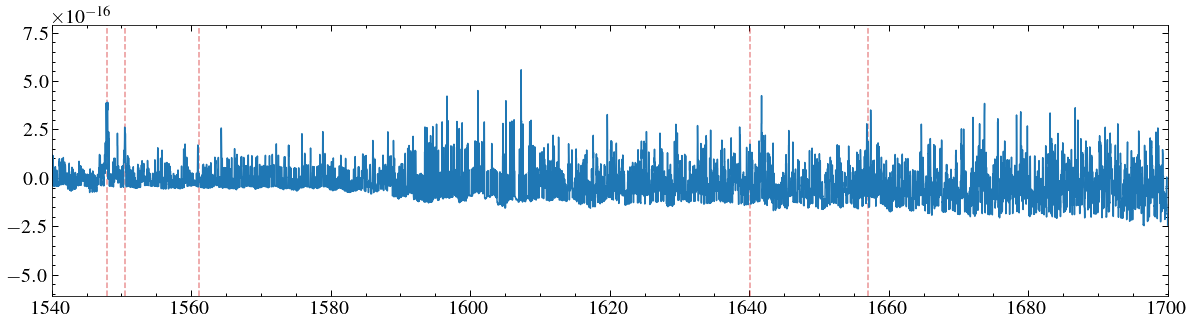

In [74]:

plt.figure(figsize=(20, 5))
#[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in dv_lines]
[plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in combined_lines]
plt.plot(w, f1)
plt.xlim(1160, 1420)
plt.show()
plt.figure(figsize=(20, 5))
#[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in dv_lines]
[plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in combined_lines]
plt.plot(w, f1)
plt.xlim(1540, 1700)

- define line ranges using highest and lowest in groups +/-0.5 A
- mask out lines to make a "continum" spectrum
- integrate over lines.
- fit to 1A? of continumum each side.
- line flux - continum flux 


In [131]:
def wavelength_edges(w, gap=10):
    """
    Calulates w0 and w1, accounting for gaps induced by masking etc
    """
    diff = np.diff(w)
   # diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    diff = np.insert(diff, (0, len(diff)), (diff[0], diff[-1])) #adds an extravalue to make len(diff) = len(w)+1
    w0 = []
    w1 = []
    for i, wi in enumerate(w):
        w0i, w1i = diff[i]/2, diff[i+1]/2
        if (max(w0i, w1i)/min(w0i, w1i)) > gap:
            w0i, w1i = min(w0i, w1i), min(w0i, w1i)
        w0.append(wi - w0i)
        w1.append(wi + w1i)
   # w0 = w - diff/2.
   # w1 = w + diff/2.
    
    return np.array(w0), np.array(w1)

def mask_maker(x, pairs, include=True):
    """
    creates a mask for a spectrum that excudes between pairs from an array
    """
    b = pairs[::2]
    r = pairs[1::2]
    C = np.zeros_like(x,dtype='bool')
    for i in range(len(b)):
        C |= (x>b[i])&(x<r[i])
    if include:
        return ~C
    else:
        return C
    
pairs = []
for group in grouped_lines:
    pairs.append(min(group)-0.5)    
    pairs.append(max(group)+0.5)

mask = mask_maker(w, pairs)
cw, cf, ce = w[mask], f1[mask], e1[mask]


line_fluxes = []
line_errors = []
for i, group in enumerate(grouped_lines):
    linemask = (w > min(group)-0.5) & (w < max(group)+0.5)
    contmask = (cw > min(group)-2.5) & (cw < min(group)-0.5) | (cw > max(group)+0.5) & (cw < max(group)+2.5)
    lw, lf, le = w[linemask], f1[linemask], e1[linemask]
   # print(len(lw))
    if len(lw) >1:
        cfit = np.polyfit(cw[contmask], cf[contmask], 2)
        w0, w1 = wavelength_edges(lw)
        lineflux = np.sum((w1-w0)*lf)
        line_error = (np.sum(le**2 * (w1-w0)**2))**0.5
        cflux = np.sum((w1-w0)*np.polyval(cfit, lw))
        cerror = (line_error/abs(lineflux))*abs(cflux)
        flux = lineflux - cflux
        flux_error = (line_error**2+cerror**2)**0.5
        print(np.unique(grouped_names[i]), np.mean(group), flux*1e18,flux_error*1e18)
        line_fluxes.append(flux)
        line_errors.append(flux_error)
        
      #  plt.figure(figsize=(4,4))
      #  plt.step(lw, lf, where='mid')
      #  plt.step(cw[contmask], cf[contmask], where='mid')
      #  plt.plot(cw[contmask], np.polyval(cfit, cw[contmask]))
      #  plt.plot(lw[1:], np.polyval(cfit, lw[1:]))
        
        #flux = ((2*np.pi)**0.5) * amp * std
       # print(len(group), flux/len(group))
        mod_std = 0.1
        model_amp =  (flux/len(group)) / (mod_std*((2*np.pi)**0.5)) 
       # print(model_amp)
        model = models.Gaussian1D(model_amp, group[0], mod_std)
        if len(group) > 1:
            for li in group[1:]:
                model = model + models.Gaussian1D(model_amp, li, mod_std)
      #  plt.plot(lw, model(lw))
        
      #  plt.show()


['C III'] 1175.433359023272 121.75845650621854 6.202364258466596
['Si III'] 1206.2724236072745 59.89887740790351 4.012759130488205
['N V'] 1238.5883536460346 38.54989755896886 3.1125151437510863
['N V'] 1242.5706056522345 21.106738385070834 2.332867201262898
['Si II'] 1264.4994867097225 -0.25591797884603384 2.5903966189359187
['Si III'] 1294.299889244692 6.5573768238670205 5.197063120886561
['Si III'] 1298.6740676346303 5.6172674257230035 11.473519470235864
['O I' 'Si III'] 1301.4135530719855 311.754484839825 850.6624750090854
['O I' 'Si II' 'Si III'] 1303.9384121563414 -366322.5831788029 142329.1474672159
['C II'] 1323.7033663349064 2.797130934766674 6.104263559314983
['C II'] 1334.2733809494032 30.494526529258696 3.5584856549489774
['C II'] 1335.4581584104494 61.18872211570091 3.6406802471258595
['Si IV'] 1393.493257569842 19.38749337919224 4.015107116232075
['Si IV'] 1402.5065645836228 -2.802575648165927 6.038229871380264
['C IV'] 1547.9102531383828 97.79736235807121 9.2514888406432

In [90]:
#ft1 = line_fluxes
#et1 = line_errors

In [102]:
"""x = np.arange(len(line_fluxes))
print(line_fluxes)
print(ft1)

plt.scatter(x, abs(np.array(line_fluxes))/abs(np.array(ft1)))
plt.show()
plt.scatter(x, abs(np.array(line_errors))/abs(np.array(et1)))
"""

'x = np.arange(len(line_fluxes))\nprint(line_fluxes)\nprint(ft1)\n\nplt.scatter(x, abs(np.array(line_fluxes))/abs(np.array(ft1)))\nplt.show()\nplt.scatter(x, abs(np.array(line_errors))/abs(np.array(et1)))\n'

Deleting first and last points does have an effect- need to use w0, w1.

Test getting observed dv off the strongest lines? See if C4 lines are strongest for whole sample? Cii1334 lines are popular

-73.20759791464066 km / s


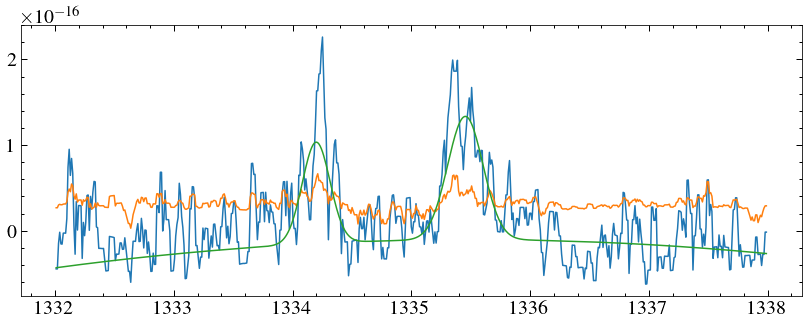

In [147]:
fitter = fitting.LevMarLSQFitter()
mask = (w > 1332) & (w < 1338) 
plt.plot(w[mask], f1[mask])
plt.plot(w[mask], e1[mask])


dv_guess = -56.3*u.km/u.s
lw, lf, le = w[mask], f1[mask], e1[mask]
lines = [1334.524, 1335.709]

lines_guess = dv_guess.to(u.AA, equivalencies=u.doppler_optical(lines*u.AA)).value

gg_init = models.Polynomial1D(2) + models.Gaussian1D(1, lines_guess[0], 0.1) + models.Gaussian1D(1, lines_guess[1], 0.1)
gg_fit = fitter(gg_init, lw, lf, weights=1/le, maxiter=10000)
plt.plot(lw, gg_fit(lw))

dv1 = (gg_fit[1].mean*u.AA).to(u.km/u.s, equivalencies=u.doppler_optical(lines[0]*u.AA))
print(dv1)
dv1 = (gg_fit[2].mean*u.AA).to(u.km/u.s, equivalencies=u.doppler_optical(lines[0]*u.AA))
